In [565]:
import numpy as np
import pandas as pd
import praw
import time
from pmaw import PushshiftAPI
import openai
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import nltk
from statistics import mean
from sklearn import metrics
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [132]:
df = pd.read_csv("combined_data_for_use.csv", index_col=0)

In [133]:
reddit = pd.read_csv("reddit_data_pull.csv", index_col=0)

In [134]:
final = pd.read_csv("final_dataset.csv", index_col=0)

In [135]:
reddit.rename(columns={"title": "question"}, inplace=True)

In [170]:
df_exp = pd.merge(df, reddit[["question", "selftext"]], how='inner', left_index=True,
                     right_index=True,)
df_exp.drop(columns = "question_y", inplace=True)
df_exp.rename(
    {"question_x": "question"}, axis = 1, inplace=True)

In [171]:
df_exp.head()

,question,ai_answer,human_answer,selftext
0,Redditors who make +$100K and aren’t being kil...,\n\nSome Redditors who make +$100K and aren’t ...,If that’s important to you then not working at...,careerguidance
1,Quitting after 8 years without notice. Am I wr...,"\n\nYes, you are wrong. You are allowed to qui...",You are not wrong.\nLoyalty is a two-way stree...,careerguidance
2,My boss is pressuring to tell him where my new...,\n\nIf you are in a position of authority and ...,No. Do not say anything to him. Managers are n...,careerguidance
3,"BS’ed my way into a 160K job offer, am I crazy...",\n\nThere is no definitive answer to this ques...,Literally every single person I've known who e...,careerguidance
4,My boss confronted me about only working 7 hou...,\n\nIf your boss confronts you about working o...,Work an extra 15 minutes and tell him you didn...,careerguidance


In [19]:
df_exp["selftext"].unique()

array(['careerguidance', 'cscareerquestions', 'askscience', 'AsksReddit',
       'AskHistory'], dtype=object)

In [275]:
df_exp.columns

Index(['question', 'ai_answer', 'human_answer', 'selftext', 'q_word_count',
       'ha_word_count', 'aia_word_count', 'ha_words'],
      dtype='object')

Text(0.5, 0.98, 'Distribution of Word Count by Subreddit - Human Answers')

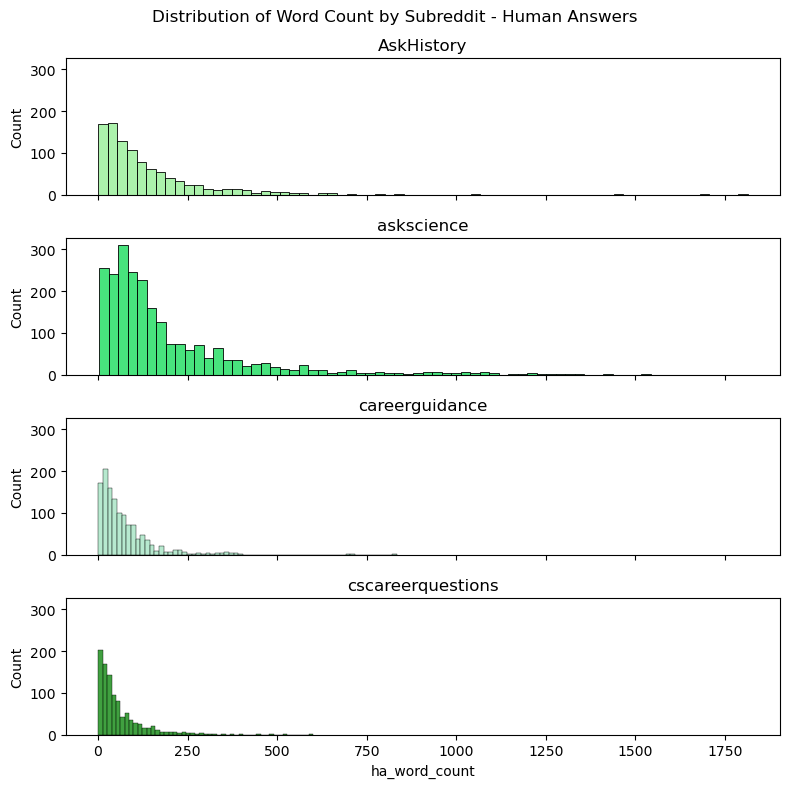

In [273]:
import seaborn as sns
fig, axes = plt.subplots(4, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_exp[df_exp['selftext'] == 'AskHistory'], x='ha_word_count', color='#90EE90', ax=axes[0]).set(title='AskHistory')
sns.histplot(data=df_exp[df_exp['selftext'] == 'askscience'], x='ha_word_count', color='#0BDA51', ax=axes[1]).set(title='askscience')
sns.histplot(data=df_exp[df_exp['selftext'] == 'careerguidance'], x='ha_word_count', color='#9FE2BF', ax=axes[2]).set(title='careerguidance')
sns.histplot(data=df_exp[df_exp['selftext'] == 'cscareerquestions'], x='ha_word_count', color='#008000', ax=axes[3]).set(title='cscareerquestions');

# Add a Super Title
fig.suptitle('Distribution of Word Count by Subreddit - Human Answers', ha='center')


Text(0.5, 0.98, 'Distribution of Word Count by Subreddit - AI Answers')

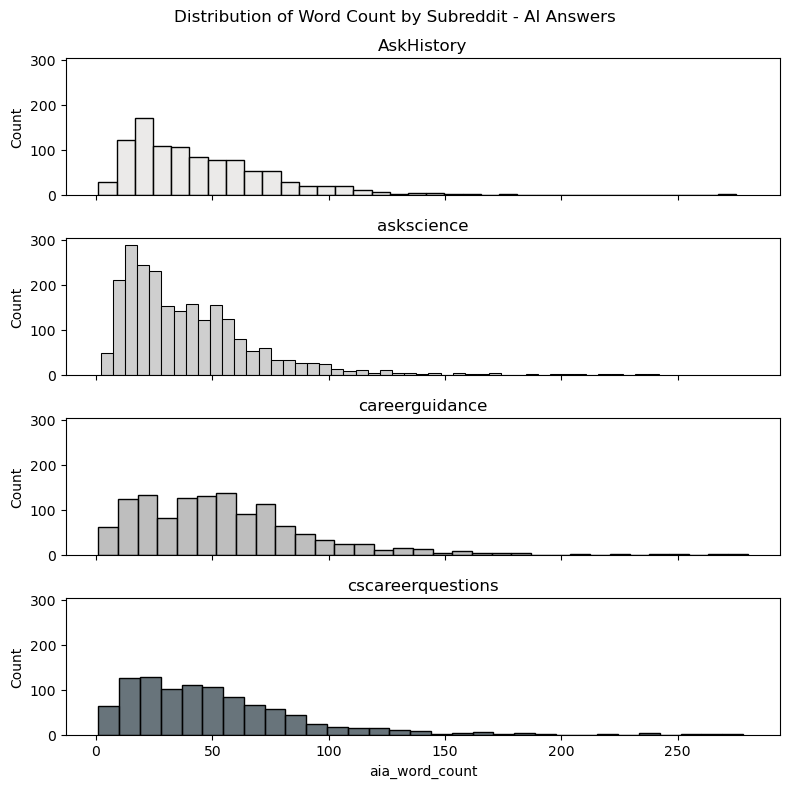

In [276]:
import seaborn as sns
fig, axes = plt.subplots(4, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_exp[df_exp['selftext'] == 'AskHistory'], x='aia_word_count', color='#E5E4E2', ax=axes[0]).set(title='AskHistory')
sns.histplot(data=df_exp[df_exp['selftext'] == 'askscience'], x='aia_word_count', color='#C0C0C0', ax=axes[1]).set(title='askscience')
sns.histplot(data=df_exp[df_exp['selftext'] == 'careerguidance'], x='aia_word_count', color='#A9A9A9', ax=axes[2]).set(title='careerguidance')
sns.histplot(data=df_exp[df_exp['selftext'] == 'cscareerquestions'], x='aia_word_count', color='#36454F', ax=axes[3]).set(title='cscareerquestions');

# Add a Super Title
fig.suptitle('Distribution of Word Count by Subreddit - AI Answers', ha='center')


In [296]:
Lemmed_top_human = df_consolidated_wc['human_answer_l']
stopwords = nltk.corpus.stopwords.words('english')
new_stop_words = ["wa", "ha", "s"]

cvec_lemm_ha = CountVectorizer(stop_words=stopwords)
cvec_lemm_ha.fit(Lemmed_top_human)
cvec_lemm_ha_data = cvec_lemm_ha.transform(Lemmed_top_human)
ha_lemm_df = pd.DataFrame(cvec_lemm_ha_data.todense(), columns=cvec_lemm_ha.get_feature_names_out())

ha_lemm_df_master = pd.concat([ha_lemm_df, df_consolidated_wc['selftext']], axis=1)

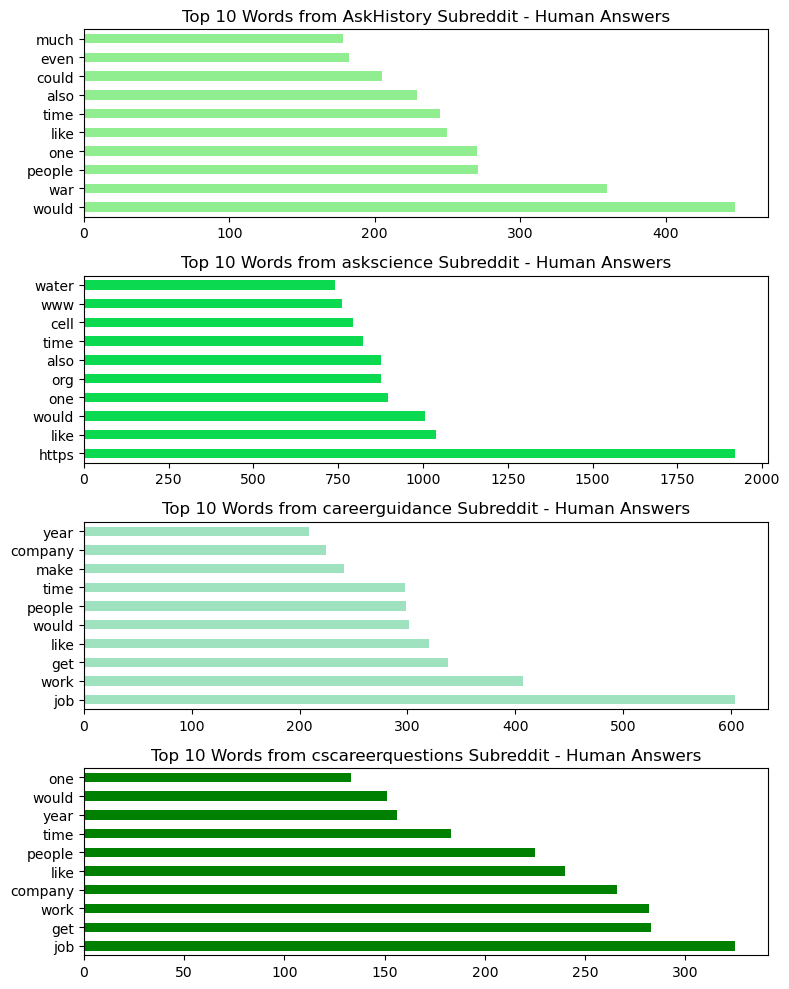

In [297]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10), tight_layout=True)

(ha_lemm_df_master[ha_lemm_df_master['selftext'] == 'AskHistory']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from AskHistory Subreddit - Human Answers', color='#90EE90', ax=axes[0]));

(ha_lemm_df_master[ha_lemm_df_master['selftext'] == 'askscience']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from askscience Subreddit - Human Answers', color='#0BDA51', ax=axes[1]));

(ha_lemm_df_master[ha_lemm_df_master['selftext'] == 'careerguidance']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from careerguidance Subreddit - Human Answers', color='#9FE2BF', ax=axes[2]));

(ha_lemm_df_master[ha_lemm_df_master['selftext'] == 'cscareerquestions']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from cscareerquestions Subreddit - Human Answers', color='#008000', ax=axes[3]));


In [286]:
Lemmed_top = df_consolidated_wc['ai_answer_l']
stopwords = nltk.corpus.stopwords.words('english')
new_stop_words = ["wa", "ha", "s"]
stopwords.extend(new_stop_words)

cvec_lemm_ai = CountVectorizer(stop_words=stopwords)
cvec_lemm_ai.fit(Lemmed_top)
cvec_lemm_ai_data = cvec_lemm_ai.transform(Lemmed_top)
ai_lemm_df = pd.DataFrame(cvec_lemm_ai_data.todense(), columns=cvec_lemm_ai.get_feature_names_out())

ai_lemm_df_master = pd.concat([ai_lemm_df, df_consolidated_wc['selftext']], axis=1)

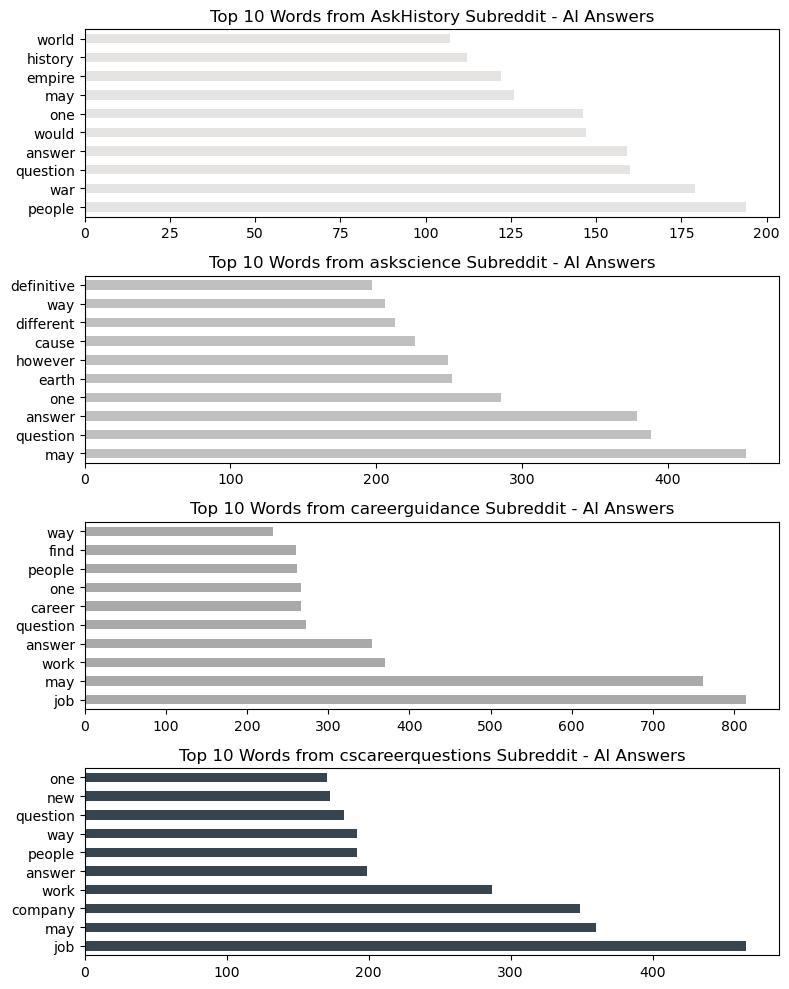

In [295]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10), tight_layout=True)

(ai_lemm_df_master[ai_lemm_df_master['selftext'] == 'AskHistory']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from AskHistory Subreddit - AI Answers', color='#E5E4E2', ax=axes[0]));

(ai_lemm_df_master[ai_lemm_df_master['selftext'] == 'askscience']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from askscience Subreddit - AI Answers', color='#C0C0C0', ax=axes[1]));

(ai_lemm_df_master[ai_lemm_df_master['selftext'] == 'careerguidance']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from careerguidance Subreddit - AI Answers', color='#A9A9A9', ax=axes[2]));

(ai_lemm_df_master[ai_lemm_df_master['selftext'] == 'cscareerquestions']
    .drop(columns=['selftext'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from cscareerquestions Subreddit - AI Answers', color='#36454F', ax=axes[3]));


In [305]:
df_exp_subreddit = df_exp.groupby('selftext').aggregate({'question':'count','q_word_count': "mean", "ha_word_count": "mean","aia_word_count": "mean" })

In [306]:
subreddit_counts = df_exp_subreddit[df_exp_subreddit["question"]>1]

In [307]:
subreddit_counts.reset_index()

,selftext,question,q_word_count,ha_word_count,aia_word_count
0,AskHistory,991,17.982846,135.215943,44.128153
1,askscience,2281,18.922402,191.526523,39.262166
2,careerguidance,1252,17.667732,70.613419,54.622204
3,cscareerquestions,998,14.094188,60.616232,50.206413


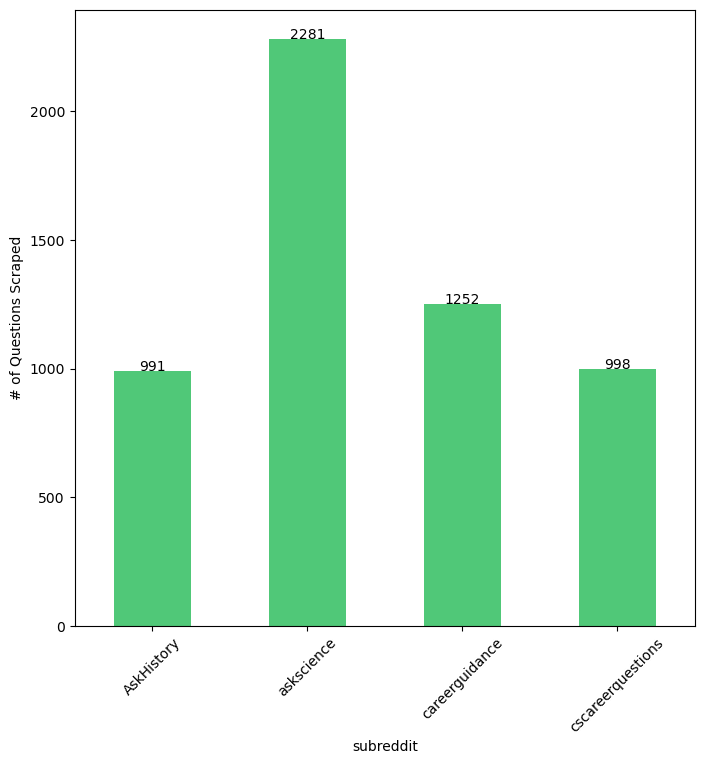

In [335]:
X = ["AskHistory", "askscience", "careerguidance", "cscareerquestions"]
#y = subreddit_counts[subreddit_counts["question"]]
#barplot_counts = subreddit_counts["question"].plot.bar(rot = 45, fontsize = 8, color = "#50C878")
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i],ha = 'center')
        
fig = plt.figure(figsize=(8,8))
subreddit_counts["question"].plot(kind="bar", color = "#50C878", fontsize=10)
#subreddit_counts.plot.bar(X, y, color = "#50C878", width = 0.4)
plt.xlabel("subreddit")
plt.ylabel("# of Questions Scraped")
plt.xticks(rotation = 45)
addlabels(X ,subreddit_counts["question"])

#code adapted from https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/


In [ ]:
### Remove questions where human_answer token count < 300 (same as imposed ai_answer token count)

In [308]:
df_exp_filtered = df_exp[df_exp["ha_word_count"]<=300]

In [309]:
df_exp_subreddit_filtered = df_exp_filtered.groupby('selftext').aggregate({
    'question':'count',
    'q_word_count': "mean", 
    "ha_word_count": "mean",
    "aia_word_count": "mean" })

In [310]:
subreddit_counts_filtered = df_exp_subreddit_filtered[df_exp_subreddit_filtered["question"]>1]

In [311]:
subreddit_counts_filtered.reset_index()

,selftext,question,q_word_count,ha_word_count,aia_word_count
0,AskHistory,885,18.025989,93.620339,43.468927
1,askscience,1845,19.014092,107.719241,38.955556
2,careerguidance,1223,17.605887,63.064595,54.461161
3,cscareerquestions,981,14.130479,54.638124,50.065240


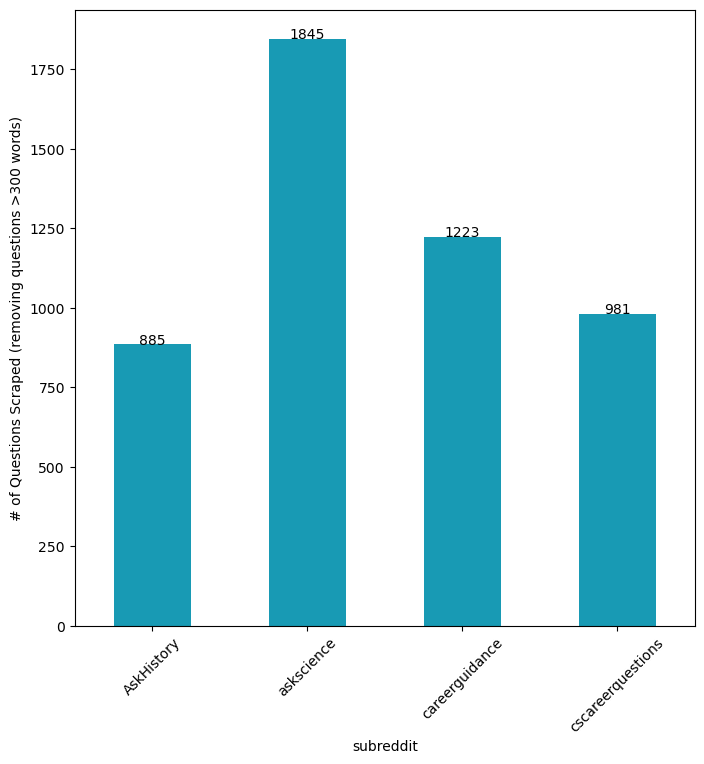

In [353]:
#barplot_counts_filtered = subreddit_counts_filtered["question"].plot.bar(rot = 45, fontsize = 8, color = "#50C878")

X = ["AskHistory", "askscience", "careerguidance", "cscareerquestions"]
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i],ha = 'center')
        
fig = plt.figure(figsize=(8,8))
subreddit_counts_filtered["question"].plot(kind="bar", color = "#189AB4", fontsize=10)
#subreddit_counts.plot.bar(X, y, color = "#50C878", width = 0.4)
plt.xlabel("subreddit")
plt.ylabel("# of Questions Scraped (removing questions >300 words)")
plt.xticks(rotation = 45)
addlabels(X ,subreddit_counts_filtered["question"])

#code adapted from https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

### Lemmatizing the answers

In [172]:
df_exp["q_word_count"] = [len(nltk.word_tokenize(p)) for p in df_exp["question"]]

In [194]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

df_lemmed = pd.DataFrame(df_exp, columns=['human_answer'])

df_lemmed['text_lemmatized'] = df_lemmed.human_answer.apply(lemmatize_text)

#df_exp["ha_words"] = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(df_exp["human_answer"])]

In [219]:
df_lemmed_ = pd.DataFrame(df_exp, columns=['ai_answer'])

df_lemmed_['ai_text_lemmatized'] = df_lemmed_.ai_answer.apply(lemmatize_text)

#df_exp["ha_words"] = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(df_exp["human_answer"])]

In [396]:
df_expf = pd.merge(df_lemmed, df_lemmed_[["ai_text_lemmatized"]], how='inner', left_index=True,
                     right_index=True,)

In [397]:
df_exp_f = pd.merge(df_expf, df_exp[["question"]], how='inner', left_index=True,
                     right_index=True,)

In [398]:
df_exp_f.drop(columns = "human_answer", inplace = True)
df_exp_f.rename(columns = {"text_lemmatized" : "human_answer_l", "ai_text_lemmatized" : "ai_answer_l", "question": "question"}, inplace = True)

In [10]:
# remove rows with 1 word responses: [deleted] , [removed]
# may want to research why these showed up as top comments

In [399]:
df_filteredf = df_exp_f[df_exp_f["human_answer_l"] != "[deleted]"]
df_filteredf = df_exp_f[df_exp_f["human_answer_l"] != "[removed]"]

In [411]:
#df_filteredf.loc[:,"question"] = [t if "?" in t else "" for t in df_filteredf.loc[:,"question"]]
df_filteredf.loc[:,"is_ai"] = [1 if i != "" else 0 for i in df_filteredf.loc[:,"ai_answer_l"]]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/178146770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filteredf.loc[:,"is_ai"] = [1 if i != "" else 0 for i in df_filteredf.loc[:,"ai_answer_l"]]


In [469]:
df_filtered_f = df_filteredf.copy()

In [470]:
df_filtered_f.loc[:,"is_human"] = [0 if i != "" else 1 for i in df_filteredf.loc[:,"human_answer_l"]]

In [471]:
df_filtered_f.loc[:,"is_ai"] = [1 if i != "" else 0 for i in df_filteredf.loc[:,"ai_answer_l"]]

In [472]:
df_filtered_f.loc[:,"question_dubs"] = df_filtered_f.loc[:,"question"]

In [473]:
#Recreate the dataframe for word clouds (now with lemmatized strings)
df_consolidated_wc = pd.merge(df_filtered_f, reddit[["question", "selftext"]], how='inner', left_index=True,
                     right_index=True,)

In [373]:
df_consolidated_wc.drop(columns = ["is_human", "is_ai", "question_dubs"], inplace=True)

In [374]:
df_consolidated_wc.drop(columns = ["question_y"], inplace=True)
df_consolidated_wc.rename(columns = {"question_x": "question"}, inplace=True)

In [475]:
df_filtered_f.rename(columns = {
    "question_dubs": "question",
    "is_ai_l": "is_human",
    "ai answer": "human_answer_l"
    
}, inplace=True)

In [479]:
cols = ["human_answer_l","is_human", "question","ai_answer_l", "is_ai", "question"]
df_filtered_u = df_filtered_f[cols]
df_filtered_w = df_filtered_u.drop(df_filtered_u.columns[[3, 7]],axis = 1)

In [481]:
df_consolidated_f = df_filtered_w[["human_answer_l","is_human"]].append(df_filtered_w[[
   "ai_answer_l", "is_ai"]].set_axis(["human_answer_l","is_human"], axis=1)).reset_index(drop=True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/1466859297.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated_f = df_filtered_w[["human_answer_l","is_human"]].append(df_filtered_w[[


In [ ]:
#create our modified clean dataframe for the model

In [484]:
df_consolidated_f.rename(columns={"human_answer_l": "answer"}, inplace=True)

In [486]:

df_consolidated_f.loc[df_consolidated_f["is_human"] == 1, "answer"] = df_consolidated_f["answer"].str.replace("I am only a machine", "")
df_consolidated_f.loc[df_consolidated_f["is_human"] == 1, "answer"] = df_consolidated_f["answer"].str.replace("As an AI language model", "")

In [491]:

df_consolidated_f.loc[df_consolidated_f["is_human"] == 1, "answer"] = df_consolidated_f["answer"].str.replace("[Removed]", "")
df_consolidated_f.loc[df_consolidated_f["is_human"] == 1, "answer"] = df_consolidated_f["answer"].str.replace("[Deleted]", "")

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/794123274.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_consolidated_f.loc[df_consolidated_f["is_human"] == 1, "answer"] = df_consolidated_f["answer"].str.replace("[Removed]", "")
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/794123274.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_consolidated_f.loc[df_consolidated_f["is_human"] == 1, "answer"] = df_consolidated_f["answer"].str.replace("[Deleted]", "")


In [ ]:
#separate into subreddit datasets

In [488]:
df_consolidated_wc.drop(df_consolidated_wc.columns[[2, 5,6]],axis = 1)

,human_answer_l,ai_answer_l,is_ai,is_human,selftext
0,If that’s important to you then not working at...,Some Redditors who make +$100K and aren’t bein...,1,0,careerguidance
1,You are not wrong. Loyalty is a two-way street...,"Yes, you are wrong. You are allowed to quit af...",1,0,careerguidance
2,No. Do not say anything to him. Managers are n...,If you are in a position of authority and are ...,1,0,careerguidance
3,Literally every single person I've known who e...,There is no definitive answer to this question...,1,0,careerguidance
4,Work an extra 15 minute and tell him you didn’...,If your bos confronts you about working only 7...,1,0,careerguidance
...,...,...,...,...,...
5518,Accurate mechanical clocks; the predecessor of...,Some thing the Ottoman Empire wa known for inc...,1,0,AskHistory
5519,"The honest answer is that nobody really knows,...",Romania maintained a Romance language due to t...,1,0,AskHistory
5520,You had a sort of perfect storm swirling. Euro...,"The cause of World War I is unknown, but it is...",1,0,AskHistory
5521,Are you referring to ham-boning? It's a type o...,A knee slapping entertainment is typically ref...,1,0,AskHistory


In [ ]:
df_exp_filtered = df_exp[df_exp["ha_word_count"]<=300]

In [489]:
df_history = df_consolidated_wc[df_consolidated_wc["selftext"]=="AskHistory"]
df_science = df_consolidated_wc[df_consolidated_wc["selftext"]=="askscience"]
df_career = df_consolidated_wc[df_consolidated_wc["selftext"]=="careerguidance"]
df_cscareer = df_consolidated_wc[df_consolidated_wc["selftext"]=="cscareerquestions"]

In [490]:
df_consolidated_history = df_history[["human_answer_l","is_human"]].append(df_history[[
   "ai_answer_l", "is_ai"]].set_axis(["human_answer_l","is_human"], axis=1)).reset_index(drop=True)

df_consolidated_science = df_science[["human_answer_l","is_human"]].append(df_science[[
   "ai_answer_l", "is_ai"]].set_axis(["human_answer_l","is_human"], axis=1)).reset_index(drop=True)

df_consolidated_career = df_career[["human_answer_l","is_human"]].append(df_career[[
   "ai_answer_l", "is_ai"]].set_axis(["human_answer_l","is_human"], axis=1)).reset_index(drop=True)

df_consolidated_csquestions = df_cscareer[["human_answer_l","is_human"]].append(df_cscareer[[
   "ai_answer_l", "is_ai"]].set_axis(["human_answer_l","is_human"], axis=1)).reset_index(drop=True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/146765256.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated_history = df_history[["human_answer_l","is_human"]].append(df_history[[
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/146765256.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated_science = df_science[["human_answer_l","is_human"]].append(df_science[[
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/146765256.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated_career = df_career[["human_answer_l","is_human"]].append(df_career[[
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_18853/146765256.py:10: FutureWar

In [493]:
df_consolidated_history.rename(columns={"human_answer_l": "answer"}, inplace=True)
df_consolidated_science.rename(columns={"human_answer_l": "answer"}, inplace=True)
df_consolidated_career.rename(columns={"human_answer_l": "answer"}, inplace=True)
df_consolidated_csquestions.rename(columns={"human_answer_l": "answer"}, inplace=True)

### Word Clouds for word frequency in Human and AI answers by subreddit

In [253]:
history = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="AskHistory"].human_answer_l)
science = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="askscience"].human_answer_l)
career = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="careerguidance"].human_answer_l)
career_q = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="cscareerquestions"].human_answer_l)

In [261]:
history_ai = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="AskHistory"].ai_answer_l)
science_ai = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="askscience"].ai_answer_l)
career_ai = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="careerguidance"].ai_answer_l)
career_q_ai = " ".join(review for review in df_consolidated_wc[df_consolidated_wc["selftext"]=="cscareerquestions"].ai_answer_l)

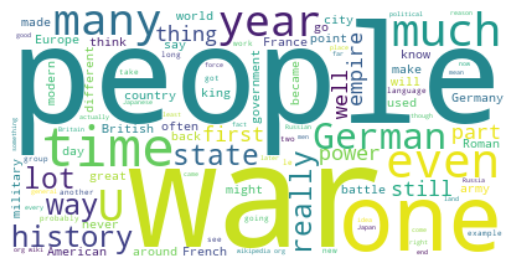

In [355]:

stopwords = set(STOPWORDS)
stopwords.update(["ha", "wa", "http", "s", "https", "com"])


# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(history)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

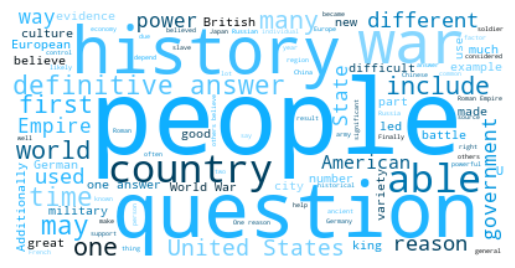

In [356]:
# Create and generate a word cloud image:
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(200,100%%, %d%%)" % np.random.randint(1,80))

wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(history_ai)
wordcloud.recolor(color_func = grey_color_func)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

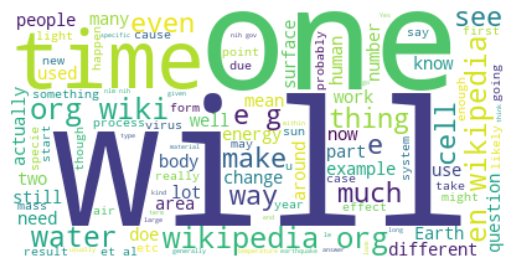

In [357]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(science)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

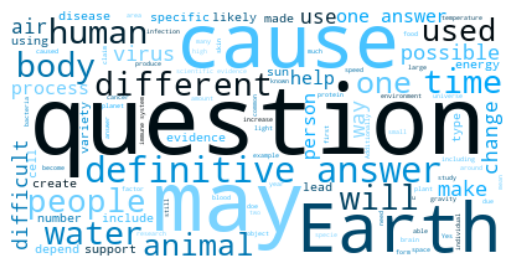

In [358]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(science_ai)
wordcloud.recolor(color_func = grey_color_func)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

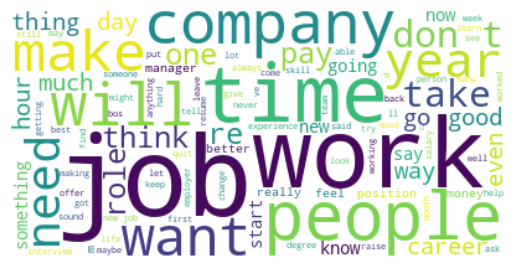

In [359]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(career)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

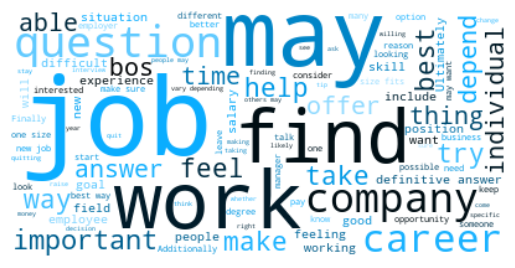

In [360]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(career_ai)
wordcloud.recolor(color_func = grey_color_func)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

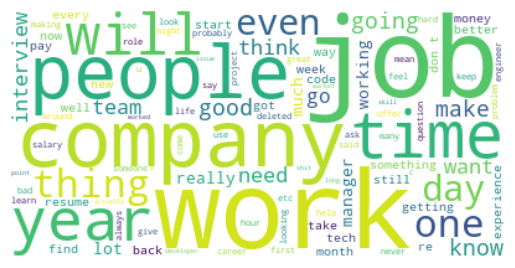

In [361]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(career_q)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

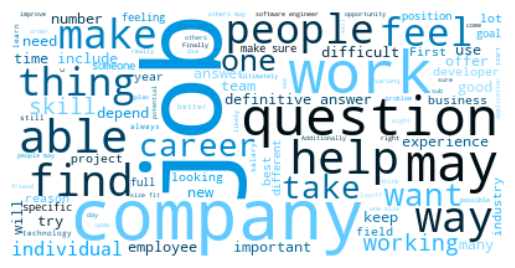

In [362]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(career_q_ai)
wordcloud.recolor(color_func = grey_color_func)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Model

In [494]:
#Repeating all the models with lemmatized features
X = df_consolidated_f["answer"]
y = df_consolidated_f["is_human"]

In [495]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

### Bernoulli

In [543]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [544]:
tv = TfidfVectorizer(min_df=2)
tv.fit(X_train)

X_train_tv = tv.transform(X_train)
X_test_tv = tv.transform(X_test)

#### Count Vectorizer

In [496]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [501]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [502]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [503]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [504]:
gs.best_score_

0.9573465592064476

In [505]:
print(gs.score(X_train,y_train))
print(gs.score(X_test,y_test))


0.9606943583384997
0.9680178505020454


#### TFIDF

In [507]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [508]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [509]:
gs_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [510]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [511]:
gs_tvec.best_score_

0.9573465592064476

In [512]:
print(gs_tvec.score(X_train,y_train))
print(gs_tvec.score(X_test,y_test))

0.9606943583384997
0.9680178505020454


### Multinomial

#### Count Vectorizer

In [513]:
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [516]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [517]:
gs_mnb = GridSearchCV(pipe_mnb, 
                  pipe_params, 
                  cv = 5)

In [518]:
gs_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [519]:
gs_mnb.best_score_

0.9971481711097333

In [520]:
print(gs_mnb.score(X_train,y_train))
print(gs_mnb.score(X_test,y_test))


0.997024178549287
0.9977686872443288


#### TFIDF

In [521]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [522]:
pipe_tvec_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [523]:
gs_tvec_mnb = GridSearchCV(pipe_tvec_mnb, 
                  pipe_params_tvec, 
                  cv = 5)

In [581]:
gs_tvec_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [525]:
gs_tvec_mnb.best_score_

0.9971481711097334

In [526]:
print(gs_tvec_mnb.score(X_train,y_train))
print(gs_tvec_mnb.score(X_test,y_test))

0.9972721636701798
0.9981405727036073


### Logistic Regression

#### Count Vectorizer

In [527]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [528]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [529]:
gs_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [530]:
gs_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [531]:
print(gs_logr.score(X_train,y_train))
print(gs_logr.score(X_test,y_test))

0.9973961562306262
0.9940498326515433


In [532]:
gs_logr.best_score_

0.9941723496590205

#### TFIDF

In [533]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [535]:
pipe_params_ = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [536]:
gs_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                  pipe_params_, 
                  cv = 5)

In [537]:
gs_tvec_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [538]:
print(gs_tvec_logr.score(X_train,y_train))
print(gs_tvec_logr.score(X_test,y_test))

0.9976441413515189
0.9947936035701004


In [539]:
gs_tvec_logr.best_score_

0.9961562306261623

### Decision Tree

In [540]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [541]:
dtc = DecisionTreeClassifier()

In [545]:
dt = dtc.fit(X_train_cv, y_train)

In [546]:
print(dt.score(X_train_cv, y_train))
print(dt.score(X_test_cv, y_test))

0.9997520148791073
0.9918185198958721


### Random Forest

#### Count Vectorizer

In [547]:
rf = RandomForestClassifier()

In [548]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [549]:
print(gs_dt.best_score_)
print(gs_dt.best_params_)

0.9950402975821451
{'max_depth': None, 'n_estimators': 200}


In [550]:
gs_dt.best_estimator_

RandomForestClassifier(n_estimators=200)

In [551]:
gs_dt.score(X_test_cv, y_test)

0.995165489029379

In [552]:
gs_dt.score(X_train_cv, y_train)

0.9997520148791073

#### TFIDF

In [553]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_tvec = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_tvec.fit(X_train_tv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [554]:
print(gs_dt_tvec.best_score_)
print(gs_dt_tvec.best_params_)

0.9947923124612522
{'max_depth': None, 'n_estimators': 200}


In [556]:
gs_dt_tvec.best_estimator_

RandomForestClassifier(n_estimators=200)

In [557]:
gs_dt_tvec.score(X_test_tv, y_test)

0.9955373744886575

In [558]:
gs_dt_tvec.score(X_train_tv, y_train)

0.9997520148791073

### ADA Boost

#### Count Vectorizer + Logistic Regression

In [559]:
abc = AdaBoostClassifier(random_state = 42)

In [560]:
dt_abc = abc.fit(X_train_cv, y_train)

In [561]:
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.9942963422194668
0.9929341762737077


In [562]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=100)
dt_abc = abc.fit(X_train_cv, y_train)
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.9997520148791073
0.995165489029379


In [563]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=1000)
dt_abc = abc.fit(X_train_cv, y_train)
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.9997520148791073
0.995165489029379


In [566]:
abc_logreg = AdaBoostClassifier(random_state = 42, n_estimators=1000, estimator=LogisticRegression())
abc_logreg.fit(X_train_cv, y_train)
abc_logreg.score(X_train_cv, y_train)
abc_logreg.score(X_test_cv, y_test)

0.9966530308664932

In [567]:
abc_logreg.score(X_train_cv, y_train)

0.9997520148791073

#### TFIDF + Logistic Regression

In [568]:
abc = AdaBoostClassifier(random_state = 42)

In [569]:
dt_abc_tv = abc.fit(X_train_tv, y_train)

In [570]:
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.9947923124612523
0.9918185198958721


In [571]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=100)
dt_abc_tv = abc.fit(X_train_tv, y_train)
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.9997520148791073
0.9929341762737077


In [572]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=1000)
dt_abc_tv = abc.fit(X_train_tv, y_train)
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.9997520148791073
0.9944217181108219


In [573]:
abc_logreg_tv = AdaBoostClassifier(random_state = 42, n_estimators=1000, estimator=LogisticRegression())
abc_logreg_tv.fit(X_train_tv, y_train)
abc_logreg_tv.score(X_train_tv, y_train)
abc_logreg_tv.score(X_test_tv, y_test)

0.9962811454072146

### Selecting our model

In [574]:
# Get predictions
preds = gs.predict(X_test)

In [583]:

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(mnb, X_test, y_test, cmap='Blues', values_format='d');

NameError: name 'mnb' is not defined

In [50]:
def find_cm(preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
    
    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}")
    
    #return tn, fp, fn, tp

find_cm(preds)

TN: 808
FP: 519
FN: 30
TP: 1332
Sensitivity: 0.9779735682819384
Specificity: 0.6088922381311228
